In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error


In [20]:
def load_data(train_path: str, test_path: str, submission_path: str):
    """Read CSVs into DataFrames."""
    return (pd.read_csv(train_path),
            pd.read_csv(test_path),
            pd.read_csv(submission_path))

In [21]:

def clean_and_engineer(df: pd.DataFrame) -> pd.DataFrame:
    """Basic cleaning + feature engineering (date parts, wage ratio, dependents)."""
    df = df.copy()  # avoid SettingWithCopy
    df['DateTimeOfAccident'] = pd.to_datetime(df['DateTimeOfAccident'])
    df['DateReported']       = pd.to_datetime(df['DateReported'])
    df['ReportDelayDays']    = (df['DateReported'] - df['DateTimeOfAccident']).dt.days
    df['AccidentMonth']      = df['DateTimeOfAccident'].dt.month
    df['AccidentHour']       = df['DateTimeOfAccident'].dt.hour
    df['WagePerHour']        = df['WeeklyWages'] / df['HoursWorkedPerWeek'].replace(0, np.nan)
    df['DependentsTotal']    = df['DependentChildren'] + df['DependentsOther']
    return df

In [22]:
FEATURES = [
    'Age', 'AccidentMonth', 'AccidentHour', 'ReportDelayDays',
    'WeeklyWages', 'HoursWorkedPerWeek', 'DaysWorkedPerWeek',
    'WagePerHour', 'DependentsTotal',
    'Gender', 'MaritalStatus', 'PartTimeFullTime'
]

### Pre-processing helpers

In [23]:
def encode_and_impute(X_train: pd.DataFrame, X_test: pd.DataFrame):
    """Label‑encode categoricals then fill NaNs with 0."""
    cats = ['Gender', 'MaritalStatus', 'PartTimeFullTime']
    for col in cats:
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col].astype(str))
        X_test[col]  = le.transform(X_test[col].astype(str))
    return X_train.fillna(0), X_test.fillna(0)

### Verbose model comparison

1. We want to use grid search to try out multiple combinations of model hyperparameters and find the best-performing combination based on a scoring metric (like RMSE. 
2. It will automatically:
	- Train the model with each combination
	- Evaluate using cross-validation (e.g. 5 folds)
	- Pick the one with the lowest average RMSE

In [24]:

def compare_models(X_tr, y_tr, X_val, y_val):
    """Grid‑search three algorithms and print step‑by‑step progress."""

    model_defs = {
        'GradientBoosting': (
            GradientBoostingRegressor(random_state=42),
            {'n_estimators': [100, 200],
             'max_depth':    [3, 4],
             'learning_rate':[0.05, 0.1]}
        ),
        'RandomForest': (
            RandomForestRegressor(random_state=42),
            {'n_estimators': [100, 200],
             'max_depth':    [None, 10]}
        ),
        'CatBoost': (
            CatBoostRegressor(verbose=0, random_state=42),
            {'iterations':   [100, 200],
             'depth':        [4, 6],
             'learning_rate':[0.05, 0.1]}
        )
    }

    print("\n MODEL COMPARISON START ")
    best_rmse  = float('inf')
    best_model = None
    best_name  = None

    for name, (estimator, grid) in model_defs.items():
        total = len(ParameterGrid(grid))
        print(f"\n▶️ {name}: {total} hyper‑parameter combos")
        print(grid)
        search = GridSearchCV(
            estimator,
            grid,
            scoring='neg_root_mean_squared_error',
            cv=5,
            n_jobs=-1,
            verbose=0
        )
        search.fit(X_tr, y_tr)

        # hold‑out evaluation
        y_pred = search.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        print(f"   → Best CV RMSE on hold‑out: {rmse:.2f}")
        print(f"   → Best params: {search.best_params_}")

        if rmse < best_rmse:
            best_rmse  = rmse
            best_model = search.best_estimator_
            best_name  = name

    print("\n🏆 SELECTED MODEL →", best_name, "| RMSE:", round(best_rmse, 2))
    
    return best_model, best_rmse

### Pipeline driver

In [25]:
def main():
    # 1) Load data
    train, test, submission = load_data('train.csv', 'test.csv', 'sample_submission.csv')

    # 2) Feature engineering
    train = clean_and_engineer(train)
    test  = clean_and_engineer(test)

    # 3) Build matrices
    X = train[FEATURES]
    y = train['UltimateIncurredClaimCost']
    X_test = test[FEATURES]
    X, X_test = encode_and_impute(X, X_test)

    # 4) Split once for final validation
    X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Training rows: {X_tr.shape[0]}, Validation rows: {X_val.shape[0]}")

    # 5) Compare models → choose best
    best_model, best_rmse = compare_models(X_tr, y_tr, X_val, y_val)

    # 6) Retrain on full data and predict
    best_model.fit(X, y)
    submission['UltimateIncurredClaimCost'] = best_model.predict(X_test)
    submission.to_csv('submission.csv', index=False)
    print("✅ submission.csv saved | Public RMSE TBD on Kaggle\n")
    
    return best_model

if __name__ == '__main__':
    main()

Training rows: 43200, Validation rows: 10800

 MODEL COMPARISON START 

▶️ GradientBoosting: 8 hyper‑parameter combos
{'n_estimators': [100, 200], 'max_depth': [3, 4], 'learning_rate': [0.05, 0.1]}


/var/folders/lf/0zj1tbg167x3xkz1zpntjpq40000gn/T/ipykernel_61464/4171153047.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = le.fit_transform(X_train[col].astype(str))
/var/folders/lf/0zj1tbg167x3xkz1zpntjpq40000gn/T/ipykernel_61464/4171153047.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col]  = le.transform(X_test[col].astype(str))
/var/folders/lf/0zj1tbg167x3xkz1zpntjpq40000gn/T/ipykernel_61464/4171153047.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy 

   → Best CV RMSE on hold‑out: 29445.12
   → Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}

▶️ RandomForest: 4 hyper‑parameter combos
{'n_estimators': [100, 200], 'max_depth': [None, 10]}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


   → Best CV RMSE on hold‑out: 29852.69
   → Best params: {'max_depth': 10, 'n_estimators': 100}

▶️ CatBoost: 8 hyper‑parameter combos
{'iterations': [100, 200], 'depth': [4, 6], 'learning_rate': [0.05, 0.1]}
   → Best CV RMSE on hold‑out: 29308.80
   → Best params: {'depth': 4, 'iterations': 200, 'learning_rate': 0.05}

🏆 SELECTED MODEL → CatBoost | RMSE: 29308.8
✅ submission.csv saved | Public RMSE TBD on Kaggle



In [26]:
best_model = main()

/var/folders/lf/0zj1tbg167x3xkz1zpntjpq40000gn/T/ipykernel_61464/4171153047.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = le.fit_transform(X_train[col].astype(str))
/var/folders/lf/0zj1tbg167x3xkz1zpntjpq40000gn/T/ipykernel_61464/4171153047.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col]  = le.transform(X_test[col].astype(str))
/var/folders/lf/0zj1tbg167x3xkz1zpntjpq40000gn/T/ipykernel_61464/4171153047.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy 

Training rows: 43200, Validation rows: 10800

 MODEL COMPARISON START 

▶️ GradientBoosting: 8 hyper‑parameter combos
{'n_estimators': [100, 200], 'max_depth': [3, 4], 'learning_rate': [0.05, 0.1]}
   → Best CV RMSE on hold‑out: 29445.12
   → Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}

▶️ RandomForest: 4 hyper‑parameter combos
{'n_estimators': [100, 200], 'max_depth': [None, 10]}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


   → Best CV RMSE on hold‑out: 29852.69
   → Best params: {'max_depth': 10, 'n_estimators': 100}

▶️ CatBoost: 8 hyper‑parameter combos
{'iterations': [100, 200], 'depth': [4, 6], 'learning_rate': [0.05, 0.1]}
   → Best CV RMSE on hold‑out: 29308.80
   → Best params: {'depth': 4, 'iterations': 200, 'learning_rate': 0.05}

🏆 SELECTED MODEL → CatBoost | RMSE: 29308.8
✅ submission.csv saved | Public RMSE TBD on Kaggle



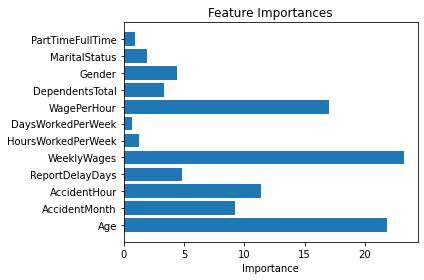

In [27]:
import matplotlib.pyplot as plt

importances = best_model.feature_importances_
plt.figure()
plt.barh(FEATURES, importances)
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

By feature importance, we get that WagePerHour, WeeklyWages, and Age are the three crucial factors that influence the model output